In [23]:
import matplotlib.pyplot as plt
import numpy
import random
import torch
import torchvision

def parse(trainData, testData):
    sort = [[] for _ in range(10)]
    for image in trainData:
        sort[image[1]].append(image[0])
    
    sample = {'data': [], 'labels': []}
    for i, images in enumerate(sort):
        sample['data'].extend(random.sample(images, 1000))
        sample['labels'].extend([i for _ in range(1000)])
        
    shuffle = list(zip(sample['data'], sample['labels']))
    random.shuffle(shuffle)
    sample['data'], sample['labels'] = zip(*shuffle)
    
    test = {'data': [], 'labels': [testData[i][1] for i in range(len(testData))]}
    for image in testData:
        test['data'].append(image[0])
    
    return sample, test

def train(trainDataset, testDataset, learningRate, epochs, alpha = -1, standardK = 0, cutoutK = 0):
    model = torchvision.models.resnet18(num_classes = 10, pretrained = False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)
    criterion = torch.nn.CrossEntropyLoss()
    
    trainX = torch.stack(trainDataset['data'])
    trainY = torch.Tensor(trainDataset['labels'])
    trainTensor = torch.utils.data.TensorDataset(trainX, trainY)
    trainLoader = torch.utils.data.DataLoader(trainTensor, batch_size = 128, num_workers = 4)
    
    testX = torch.stack(testDataset['data'])
    testY = torch.Tensor(testDataset['labels'])
    testTensor = torch.utils.data.TensorDataset(testX, testY)
    testLoader = torch.utils.data.DataLoader(testTensor, batch_size = 128, num_workers = 4)
    
    testAccuracies = []
    trainAccuracies = []
    trainLosses = []
    for _ in range(epochs):
        model.train()
        for images, labels in trainLoader:
            if standardK > 0:
                images = standard(images, standardK)
            if cutoutK > 0:
                images = cutout(images, cutoutK)
            
            x, y = images.to(device), labels.long().to(device)
            
            if alpha >= 0:
                x, y1, y2, lam = mixup(x, y, alpha)
            
            optimizer.zero_grad()
            outputs = model(x)
            
            if alpha >= 0:
                loss = lam * criterion(outputs, y1) + (1 - lam) * criterion(outputs, y2)
            else:
                loss = criterion(outputs, y)
            
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in testLoader:
                x, y = images.to(device), labels.long().to(device)

                outputs = model(x)
                
                _, predicted = torch.max(outputs, 1)
                correct += predicted.eq(y).sum().item()
                total += len(images)

            accuracy = correct / total
            testAccuracies.append(accuracy)

            correct = 0
            total = 0
            losses = 0
            for numBatches, (images, labels) in enumerate(trainLoader):
                x, y = images.to(device), labels.long().to(device)

                outputs = model(x)
                
                _, predicted = torch.max(outputs, 1)
                correct += predicted.eq(y).sum().item()
                total += len(images)
                
                loss = criterion(outputs, y)
                losses += loss.item()

            accuracy = correct / total
            trainAccuracies.append(accuracy)

            trainLosses.append(losses / numBatches)
        
    return testAccuracies, trainAccuracies, trainLosses

def mixup(x, y, alpha):
    lam = 1
    if alpha > 0:
        lam = numpy.random.beta(alpha, alpha)

    batchSize = len(x)
    if torch.cuda.is_available():
        index = torch.randperm(batchSize).cuda()
    else:
        index = torch.randperm(batchSize)

    xH = lam * x + (1 - lam) * x[index, :]
    y1, y2 = y, y[index]
    
    return xH, y1, y2, lam

def cutout(images, k):
    for i, image in enumerate(images):
        if random.randrange(2) == 0:
            continue

        channel, width, height = image.shape

        index = random.randrange(width)
        low = index - ((k - 1) // 2)
        high = index + (k // 2) + 1
        row = [low if low >= 0 else 0, high if high <= width else width]

        index = random.randrange(height)
        low = index - ((k - 1) // 2)
        high = index + (k // 2) + 1
        column = [low if low >= 0 else 0, high if high <= height else height]

        for j in range(channel):
            images[i][j][row[0]:row[1], column[0]:column[1]] = 0
        
    return images

def standard(images, k):
    for i, image in enumerate(images):
        channel, width, height = image.shape
        
        shift = random.randrange(-k, k)
        if shift < 0:
            image = torch.nn.functional.pad(image, (0, -shift, 0, 0), mode = 'constant')[:, :, -shift:]
        elif shift > 0:
            image = torch.nn.functional.pad(image, (shift, 0, 0, 0), mode = 'constant')[:, :, :-shift]
        
        shift = random.randrange(-k, k)
        if shift < 0:
            image = torch.nn.functional.pad(image, (0, 0, -shift, 0), mode = 'constant')[:, :shift, :]
        elif shift > 0:
            image = torch.nn.functional.pad(image, (0, 0, 0, shift), mode = 'constant')[:, shift:, :]
        
        if random.randrange(2) == 0:
            image = torch.flip(image, [2])
            
        images[i] = image
        
    return images

epochs = 100
learningRate = 0.001
alpha = [0.2, 0.4]
K = [16, 4]

print('Initialization complete')

Initialization complete


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0, 0, 0], std = [0.247, 0.2435, 0.2616])
    ])

trainDatasetRaw = torchvision.datasets.CIFAR10(download = True, root = './data', train = True, transform = transform)
testDatasetRaw = torchvision.datasets.CIFAR10(download = True, root = './data', train = False, transform = transform)

print('Dataset downloading and extracting complete')

Files already downloaded and verified
Files already downloaded and verified
Dataset downloading and extracting complete


In [3]:
trainDataset, testDataset = parse(trainDatasetRaw, testDatasetRaw)

print('Dataset formatting complete')

Dataset formatting complete


No Augmentations


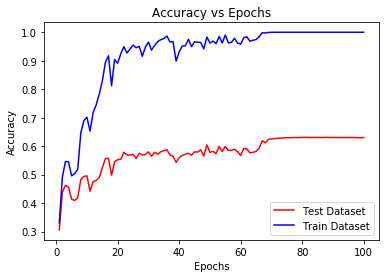

Final Test Accuracy: 0.6303


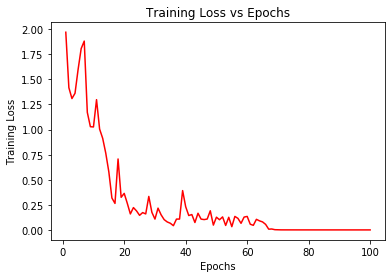

In [13]:
testAccuracies1, trainAccuracies1, trainLosses1 = train(trainDataset, testDataset, learningRate, epochs)

print('No Augmentations')

iterationVariables = numpy.arange(1, epochs + 1)
plt.plot(iterationVariables, testAccuracies1, color = 'red', label = 'Test Dataset')
plt.plot(iterationVariables, trainAccuracies1, color = 'blue', label = 'Train Dataset')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Accuracy:', testAccuracies1[-1])

plt.plot(iterationVariables, trainLosses1, color = 'red')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

Mixup: Alpha = 0.2


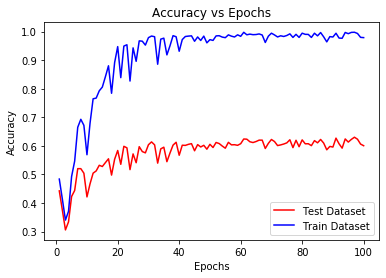

Final Test Accuracy: 0.6005


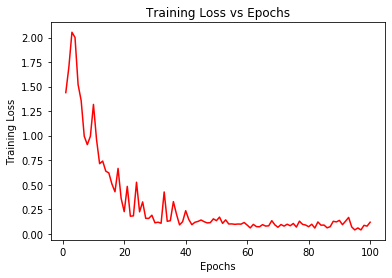

In [20]:
testAccuracies2, trainAccuracies2, trainLosses2 = train(trainDataset, testDataset, learningRate, epochs, alpha[0])

print('Mixup: Alpha = 0.2')

plt.plot(iterationVariables, testAccuracies2, color = 'red', label = 'Test Dataset')
plt.plot(iterationVariables, trainAccuracies2, color = 'blue', label = 'Train Dataset')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Accuracy:', testAccuracies2[-1])

plt.plot(iterationVariables, trainLosses2, color = 'red')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

Mixup: Alpha = 0.4


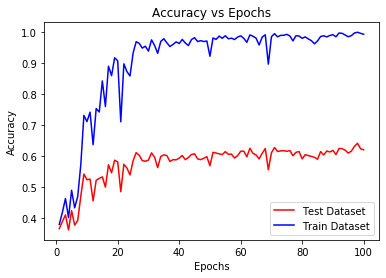

Final Test Accuracy: 0.6205


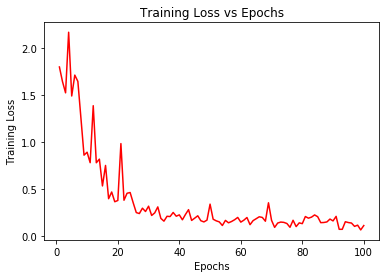

In [22]:
testAccuracies3, trainAccuracies3, trainLosses3 = train(trainDataset, testDataset, learningRate, epochs, alpha[1])

print('Mixup: Alpha = 0.4')

plt.plot(iterationVariables, testAccuracies3, color = 'red', label = 'Test Dataset')
plt.plot(iterationVariables, trainAccuracies3, color = 'blue', label = 'Train Dataset')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Accuracy:', testAccuracies3[-1])

plt.plot(iterationVariables, trainLosses3, color = 'red')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

Cutout


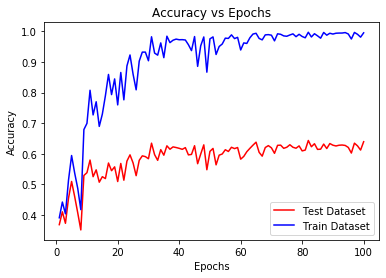

Final Test Accuracy: 0.6395


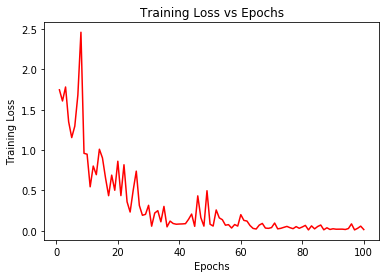

In [10]:
testAccuracies4, trainAccuracies4, trainLosses4 = train(trainDataset, testDataset, learningRate, epochs, cutoutK = K[0])

print('Cutout')

plt.plot(iterationVariables, testAccuracies4, color = 'red', label = 'Test Dataset')
plt.plot(iterationVariables, trainAccuracies4, color = 'blue', label = 'Train Dataset')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Accuracy:', testAccuracies4[-1])

plt.plot(iterationVariables, trainLosses4, color = 'red')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

Standard


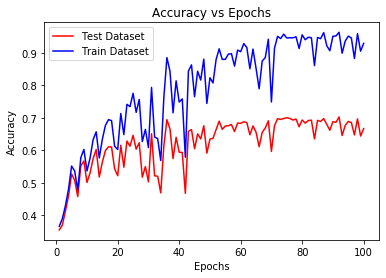

Final Test Accuracy: 0.6666


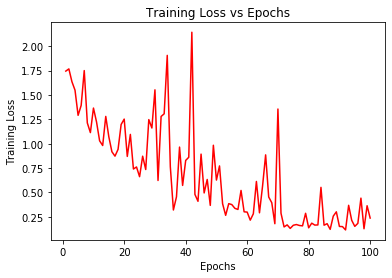

In [9]:
testAccuracies5, trainAccuracies5, trainLosses5 = train(trainDataset, testDataset, learningRate, epochs, standardK = K[1])

print('Standard')

plt.plot(iterationVariables, testAccuracies5, color = 'red', label = 'Test Dataset')
plt.plot(iterationVariables, trainAccuracies5, color = 'blue', label = 'Train Dataset')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Accuracy:', testAccuracies5[-1])

plt.plot(iterationVariables, trainLosses5, color = 'red')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

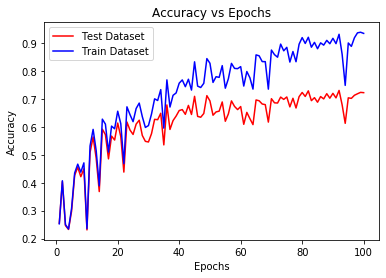

Final Test Accuracy: 0.7224


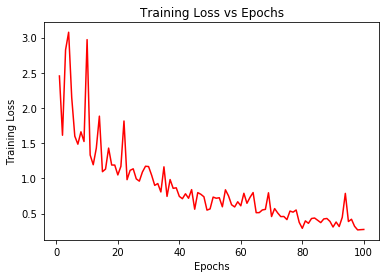

In [26]:
testAccuracies6, trainAccuracies6, trainLosses6 = train(trainDataset, testDataset, learningRate, epochs, alpha[1], K[1], K[0])

print('All Augmentations')

plt.plot(iterationVariables, testAccuracies6, color = 'red', label = 'Test Dataset')
plt.plot(iterationVariables, trainAccuracies6, color = 'blue', label = 'Train Dataset')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('Final Test Accuracy:', testAccuracies6[-1])

plt.plot(iterationVariables, trainLosses6, color = 'red')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()